In [2]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from scipy.linalg import cho_factor, cho_solve, LinAlgError
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt
import seaborn as sns

import json
import math

import requests 
from scipy.optimize import minimize, Bounds, LinearConstraint
from typing import Union, Sequence, Tuple

In [3]:
url = "https://giris.epias.com.tr"
 
headertgt = {"Content-Type" : "application/x-www-form-urlencoded",
             "Accept" : "text/plain"}
 
paramtgt = {"username" : "******",
            "password" : "******"}

In [4]:
date1 = "2025-02-01T00:00:00+03:00"
date2 = "2025-02-28T00:00:00+03:00" #sontarihin tamamını alıyor

base_path = "https://seffaflik.epias.com.tr/electricity-service"
TGT_response = requests.post(url+"/cas/v1/tickets", headers = headertgt, params = paramtgt)

header={"Content-Type" : "application/json",
        "Accept" : "application/json",
        "Accept-Language" :"en",
        "TGT" : TGT_response.text}

In [5]:
params = json.dumps({"startDate": date1, "endDate": date2,"page": {"number": "", "size": "", "total": "", "sort": {"field": "date",  "direction": "ASC"}}})
result  = requests.request("POST", base_path+"/v1/markets/dam/data/mcp",  data = params, headers=header)

In [6]:
df = pd.DataFrame(result.json()['items'])
df['date'] = pd.to_datetime(df['date'])
df['hour'] = pd.to_datetime(df['hour']).dt.hour

df["res"] = df["price"]/df["priceUsd"]*67
df["ges"] = df["price"]/df["priceEur"]*65
df['tes'] = df['hour'].apply(lambda x: 2600  if x >=12  else 1900 )
df['des'] = df["price"] * 1.03

C:\Users\gulis\AppData\Local\Temp\ipykernel_20132\2142705989.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hour'] = pd.to_datetime(df['hour']).dt.hour


In [7]:
def optimalPortfolio(df: pd.DataFrame, C: float, gamma: float) -> Tuple[pd.Series, float, float]:
    """
    Interior mean–variance optimizer for procurement weights λ under:
        min_{λ}  C μ^T λ + γ C^2 λ^T Σ λ   s.t.  1^T λ = 1

    Parameters
    ----------
    df : pd.DataFrame
        Historical unit prices (not returns): rows = time, columns = instruments.
        NaNs are dropped row-wise before estimation.
    C : float
        Deterministic total energy requirement (> 0).
    gamma : float
        Risk aversion parameter on variance term (> 0).

    Returns
    -------
    np.ndarray
        The interior optimal weight vector λ* (length = number of columns in df).

    Notes
    -----
    - This returns the *interior* solution, which requires Σ ≻ 0 (SPD).
      If Σ is singular (e.g. a riskless/constant-price instrument or perfect collinearity),
      a ValueError is raised. In that case, remove/merge collinear sources or solve
      the full KKT system with inequality constraints as appropriate.
    - Uses a Cholesky factorization; no explicit matrix inverses are formed.
    """

    #Girdilerden kaynaklı anlamsız hataları verir
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame of historical unit prices.")
    if C <= 0:
        raise ValueError("C must be strictly positive.")
    if gamma <= 0:
        raise ValueError("gamma must be strictly positive.")

    # Nan varsa düşürür ve cov için en az iki satıra ihtiyaç var. 
    df_clean = df.dropna(how="any").astype(float)
    if df_clean.shape[0] < 2 or df_clean.shape[1] < 1:
        raise ValueError("Not enough data after dropping NaNs to estimate μ and Σ.")

    mu = df_clean.mean(axis=0).to_numpy()                 # E[p] 
    Sigma = df_clean.cov().to_numpy()                     # Cov[p], ddof=1 by default
    Sigma = 0.5 * (Sigma + Sigma.T)                       # Symmetrize to dampen numerical asymmetry
    n = Sigma.shape[0]                                    # cov boyutu bulundu
    ones = np.ones(n)                                     # Birim vektör (cov boyutunda)

    # Cholesky-based solves to avoid explicit inversion ----- Bu blok, Σ’nın sağlıklı olduğunu garanti altına alıyor
    try:
        cF = cho_factor(Sigma, lower=True, check_finite=True)
    except LinAlgError as e:
        raise ValueError("Covariance matrix Σ is not SPD; interior solution undefined.") from e

    # Solve Σ x = 1 and Σ y = μ
    Sigma_inv_1 = cho_solve(cF, ones)                    #Σ^{−1} * 1
    Sigma_inv_mu = cho_solve(cF, mu)                     #Σ^{−1} * μ

    denom = float(ones @ Sigma_inv_1)                    # 1^T * Σ^{-1} * 1
    if denom <= 0 or not np.isfinite(denom):
        raise ValueError("Numerical issue: 1^T Σ^{-1} 1 must be positive and finite.")

    eta_num = 2.0 * gamma * (C**2) + C * float(ones @ Sigma_inv_mu)    # 2γC^{2} + C1^{⊤}Σ^{−1}μ
    eta = eta_num / denom                                              # [ 2γC^{2} + C1^{⊤}Σ^{−1}μ ] / [ 1^T * Σ^{-1} * 1] 

    # λ* = (1/(2 γ C^2)) [ Σ^{-1}(η 1 - C μ) ] = (1/(2 γ C^2)) (η Σ^{-1}1 - C Σ^{-1}μ)
    lam = (eta * Sigma_inv_1 - C * Sigma_inv_mu) / (2.0 * gamma * (C**2))

    # Optional: enforce the affine constraint numerically (tiny adjustment)
    lam += (1.0 - lam.sum()) * (Sigma_inv_1 / denom)                   # 1^{⊤} * λ = 1 kısıtını mikro ayarla geri oturtur düzeltme amaçlıdır.

    w = pd.DataFrame(lam, index= ['res','tes','des','ges'] )
    E = C * float(mu @ lam)
    V = (C**2) * float(lam @ Sigma @ lam)
    
    return w, E, V 

In [8]:
def optimalPortfoliononshort(
    df: pd.DataFrame,
    C: float,
    gamma: float,
    lower_bounds: Union[float, Sequence[float]] = 0.0,
    upper_bounds: Union[float, Sequence[float]] = 1.0,
    ridge: float = 1e-8,
) -> Tuple[pd.Series, float, float]:
    """
    Solve:  min_λ  C μ^T λ + γ C^2 λ^T Σ λ
            s.t.   1^T λ = 1,  lb ≤ λ ≤ ub
    df: price levels (rows=time, cols=sources). Returns (λ*, E[X], Var[X]).
    """
    if C <= 0 or gamma <= 0:
        raise ValueError("C and gamma must be > 0.")                              # risk katsayısı ve C >0 olmalı
    X = df.dropna(axis=1, how="all").dropna(axis=0, how="any").astype(float)      # Nan lar atılır
    if X.shape[0] < 2 or X.shape[1] < 1:
        raise ValueError("Not enough data.")                                      # Cov için boyutu minumum 2x2 olmalıdır

    mu = X.mean().to_numpy()                                                      # E[p]
    Sigma = X.cov(ddof=1).to_numpy()                                              # Cov[p], ddof=1 by default
    Sigma = 0.5 * (Sigma + Sigma.T) + ridge * np.eye(len(mu))                     # Symmetrize to dampen numerical asymmetry
    n = len(mu)                                                                   # mu boyutu bulundu

    # expand bounds to vectors
    lb = np.full(n, lower_bounds if np.isscalar(lower_bounds) else np.asarray(lower_bounds, float))  #lower bound
    ub = np.full(n, upper_bounds if np.isscalar(upper_bounds) else np.asarray(upper_bounds, float))  #Upper bound
    if lb.sum() > 1 + 1e-12 or ub.sum() < 1 - 1e-12:
        raise ValueError("Infeasible bounds: need sum(lb) ≤ 1 ≤ sum(ub).")                           #sum(lb) ≤ 1 ≤ sum(ub) şartını manuel test ediyor

    # feasible start: begin at lb, spread remaining mass toward ub
    w0 = lb.copy()                                         # ilk olarak ağırlıklar minimuma eşitleniyor
    rem = 1.0 - w0.sum()                                   # Eşitlik koşulundan yola çıkarak 1'den çıkarılıyor
    if rem > 0:                                            # Ağırlıklar bulunur
        room = np.maximum(ub - w0, 0.0)
        total = room.sum()
        if total > 0: w0 += rem * (room / total)           # toplamın 1 e eşit olduğu sağlanır
    w0 = np.clip(w0, lb, ub)                               # ağırlıkları (w) sınırlar içinde burakır

    def fun(w):  return C * mu @ w + gamma * (C**2) * (w @ Sigma @ w)  #fonksiyon f(w)=Cμ⊤w+γC2w⊤Σw amaç fonk  scaler
    def jac(w):  return C * mu + 2.0 * gamma * (C**2) * (Sigma @ w)    #jacobien  ∇f(w)=Cμ+2γC2Σw   1. Türev   (n,)
    def hess(w): return 2.0 * gamma * (C**2) * Sigma                   #hessian   ∇2f(w)=2γC2Σ      2. Türev   (n,n)

    cons = [LinearConstraint(np.ones((1, n)), 1.0, 1.0)]                # w vektörü ve sınırlar toplamlar 1 e eşit
    bnds = Bounds(lb, ub)                                               # Sınırlar 
    opt  = minimize(fun, w0, method="trust-constr", jac=jac, hess=hess, # Optimizasyon tam olarak burda yapılır ve newton tabanlıdır.
                   bounds=bnds, constraints=cons,
                   options={"maxiter": 500, "gtol": 1e-10, "xtol": 1e-12, "verbose": 0})  
    #gtol=1e-10	Gradyan normu bu değerden küçükse dur.
    #xtol=1e-12	w vektöründeki değişim bu değerden küçükse dur.
    #maxiter=500	Maksimum iterasyon sayısı.
    #verbose=0	Çıktı susturulmuş. 2 yapsan her adımı loglar.
    
    if not opt.success:
        raise RuntimeError(f"Optimization failed: {opt.message}")  # algoritmanın neden durduğunu açıklayan yazı "opt.***" gibi türev bilgi verilebilir.

    w = pd.Series(opt.x, index=X.columns, name="λ*")
    E = C * float(mu @ opt.x)
    V = (C**2) * float(opt.x @ Sigma @ opt.x)
    return w, E, V

In [9]:
prices = df[['res','tes','des','ges']].dropna()
C=1000.0
gamma=0.00002  #risk katsayısı
upper_bounds=[1,1,1,1]

w, E, V = optimalPortfoliononshort(prices, C=C, gamma=gamma,  upper_bounds=upper_bounds)
print("without sort position")
print(w.round(3))
print(f"Expected cost: {E:,.2f}  |  Variance: {V:,.2f}")

print("with sort position")
w1, E1, V1 =  optimalPortfolio(prices,C,gamma)
print(w1.round(3))
print(f"Expected cost: {E1:,.2f}  |  Variance: {V1:,.2f}")

without sort position
res    0.965
tes    0.035
des    0.000
ges    0.000
Name: λ*, dtype: float64
Expected cost: 2,409,528.32  |  Variance: 327,560,639.21
with sort position
         0
res  4.482
tes  0.033
des -0.015
ges -3.499
Expected cost: 2,320,113.65  |  Variance: 2,058,233,481.48


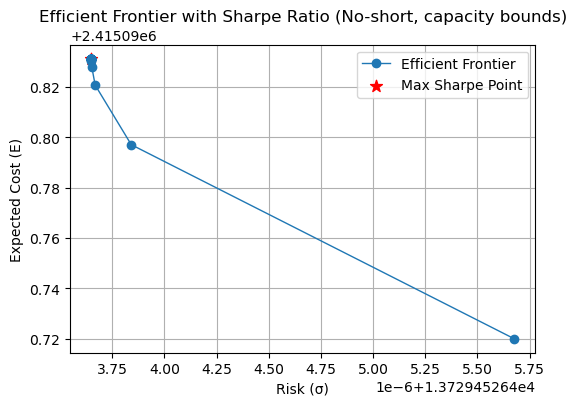

🔹 Best Sharpe Ratio = 175.9058
   γ = 7.8965e+15
   Expected Cost (E) = 2,415,090.83
   Risk (σ) = 13,729.45
   Normalde TL  = 2,478,279.70


In [12]:
gammas = np.logspace(20, 0, 40)  # 1e 106 ... 1e-3 arası 40 nokta

E_list, S_list , Sharpe_list = [], [], []

for g in gammas:
    w, E, V = optimalPortfoliononshort(prices, C=C, gamma=g,
                                       lower_bounds=0.0, upper_bounds=upper_bounds, ridge=1e-6)  
    sigma = np.sqrt(V)              # Risk (standart sapma)
    sharpe = E / sigma              # Sharpe oranı: S = E / σ
    E_list.append(E)
    S_list.append(sigma)
    Sharpe_list.append(sharpe)

# --- En yüksek Sharpe oranlı nokta ---
idx_max = np.argmax(Sharpe_list)
best_sigma = S_list[idx_max]
best_E = E_list[idx_max]
best_gamma = gammas[idx_max]
best_sharpe = Sharpe_list[idx_max]  #Hocanın istediği tanjantın eğimi
norm = df["price"].mean()*C

plt.figure(figsize=(6,4))
plt.plot(S_list, E_list, marker='o', linewidth=1, label="Efficient Frontier")
plt.scatter(best_sigma, best_E, color='red', s=80, marker='*', label='Max Sharpe Point')
plt.xlabel("Risk (σ)")
plt.ylabel("Expected Cost (E)")
plt.title("Efficient Frontier with Sharpe Ratio (No-short, capacity bounds)")
plt.legend()
plt.grid(True)
plt.show()

print(f"🔹 Best Sharpe Ratio = {best_sharpe:,.4f}")
print(f"   γ = {best_gamma:.4e}")
print(f"   Expected Cost (E) = {best_E:,.2f}")
print(f"   Risk (σ) = {best_sigma:,.2f}")
print(f"   Normalde TL  = {norm:,.2f}")

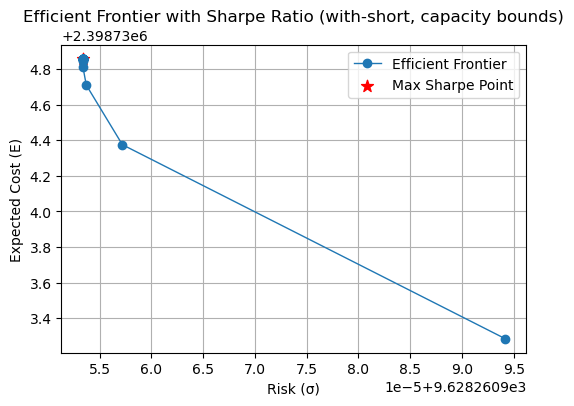

🔹 Best Sharpe Ratio = 249.1348
   γ = 3.1e+19
   Expected Cost (E) = 2,398,734.86
   Risk (σ) = 9,628.26
   Normalde TL  = 2,478,279.70


In [13]:
gammas = np.logspace(20, 0 , 40)  # 1e 106 ... 1e-3 arası 40 nokta

E_list, S_list , Sharpe_list = [], [], []

for g in gammas:
    w, E, V = optimalPortfolio(prices, C=C, gamma=g )
    sigma = np.sqrt(V)              # Risk (standart sapma)
    sharpe = E / sigma              # Sharpe oranı: S = E / σ
    E_list.append(E)
    S_list.append(sigma)
    Sharpe_list.append(sharpe)

# --- En yüksek Sharpe oranlı nokta ---
idx_max = np.argmax(Sharpe_list)
best_sigma = S_list[idx_max]
best_E = E_list[idx_max]
best_gamma = gammas[idx_max]
best_sharpe = Sharpe_list[idx_max]
norm = df["price"].mean()*C

plt.figure(figsize=(6,4))
plt.plot(S_list, E_list, marker='o', linewidth=1, label="Efficient Frontier")
plt.scatter(best_sigma, best_E, color='red', s=80, marker='*', label='Max Sharpe Point')
plt.xlabel("Risk (σ)")
plt.ylabel("Expected Cost (E)")
plt.title("Efficient Frontier with Sharpe Ratio (with-short, capacity bounds)")
plt.legend()
plt.grid(True)
plt.show()

print(f"🔹 Best Sharpe Ratio = {best_sharpe:,.4f}")
print(f"   γ = {best_gamma:.1e}")
print(f"   Expected Cost (E) = {best_E:,.2f}")
print(f"   Risk (σ) = {best_sigma:,.2f}")
print(f"   Normalde TL  = {norm:,.2f}")

-----------------------------------------------------------------------------------------------
Sharpe Oranı tanjant alfayı vermektedir. En iyi sharpe oranı en yüksek olanıdır. Çünkü risk başına beklenen gelir daha yüksek olacaktır. 

* E = Rf + S ⋅ σ

E  portföyün beklenen getirisi
Rf risksiz getiri (saatlik fiyat * C = norm)
σ portföyün riski
S Sharpe oranı (tanjantın eğimi)

* S = (E - RF) / σ